In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit


In [3]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [4]:
dfdic = {}
for idx, x in enumerate(record_list):
    dfdic[x] = pd.read_csv('mit-bih-features/'+x+ '.csv', index_col=0)

In [5]:
subject_df = pd.DataFrame()
for idx, x in enumerate(record_list):
    subject_df = pd.concat([subject_df, dfdic[x]])
subject_df = subject_df.drop(["Unnamed: 0.1"], axis=1)

In [6]:
subject_df['Mappedrhythmlabels'] = subject_df['rhythmLabel'].map({'Normal':0, 'Other':0, 'AFIB':1})

In [7]:
subject_df.head()

,subsetID,rhythmLabel,StoS,StoR,StoL,RtoS,RtoR,RtoL,LtoS,LtoR,LtoL,RMS,STD,CoefVar,Range,IQR,MAD,Mappedrhythmlabels
0,04015-0.csv,Normal,0.200000,0.057143,0.028571,0.057143,0.228571,0.142857,0.057143,0.114286,0.114286,156.276998,43.660906,0.248152,155.0,78.00,32.5,0
1,04015-1.csv,Normal,0.000000,0.052632,0.000000,0.052632,0.184211,0.236842,0.000000,0.210526,0.263158,197.783973,57.233572,0.355262,213.0,93.50,55.0,0
2,04015-2.csv,Normal,0.333333,0.083333,0.055556,0.027778,0.305556,0.083333,0.111111,0.000000,0.000000,151.638551,43.820505,0.253179,138.0,72.00,56.0,0
3,04015-3.csv,Normal,0.300000,0.175000,0.000000,0.125000,0.025000,0.125000,0.075000,0.050000,0.125000,157.611865,48.827831,0.318730,167.0,79.00,59.0,0
4,04015-4.csv,Normal,0.090909,0.151515,0.090909,0.030303,0.060606,0.212121,0.212121,0.060606,0.090909,226.855681,53.260256,0.289227,237.0,95.75,66.5,0


In [8]:
stattrees_dic =  {
    'Run Time': [],
    'Accuracy': [],
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1-Score': []
}

In [9]:
indaccs_dic = {}

#Decision Tree
DT_results = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation=KFold(n_splits=5, random_state=3, shuffle=True)
for d in range(1, 26):
    model=DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Max Depth: {}'.format(d))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    DT_results.append(scores.mean())
print(DT_results)

In [10]:
#Decision Tree 
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=DecisionTreeClassifier(max_depth=10)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattrees_dic['Run Time'].append(elapsed)
stattrees_dic['Accuracy'].append(np.mean(acc_score))
stattrees_dic['Standard Error'].append(np.std(acc_score))
stattrees_dic['Sensitivity'].append(sensitivity)
stattrees_dic['Specificity'].append(specificity)
stattrees_dic['Precision'].append(precision)
stattrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Decision Tree']=acc_score

---Run time is 7.098329482000736 seconds ---

Accuracy of each fold: 
 [0.9584039439223541, 0.961633281972265, 0.9640986132511556, 0.9670261941448383, 0.9691833590138675]
Avg accuracy: 0.9640690784608961
Std of accuracy : 
0.0038191131148569944

[[18702   724]
 [  442 12583]]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     19426
           1       0.95      0.97      0.96     13025

    accuracy                           0.96     32451
   macro avg       0.96      0.96      0.96     32451
weighted avg       0.96      0.96      0.96     32451

0.9627303613713579
0.9660652591170825
0.9769118261596322
0.9697692507129894


#Decision Tree Only With Transitoins
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=DecisionTreeClassifier(max_depth=10)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

In [11]:
#Bagging
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=RandomForestClassifier(max_features=15, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattrees_dic['Run Time'].append(elapsed)
stattrees_dic['Accuracy'].append(np.mean(acc_score))
stattrees_dic['Standard Error'].append(np.std(acc_score))
stattrees_dic['Sensitivity'].append(sensitivity)
stattrees_dic['Specificity'].append(specificity)
stattrees_dic['Precision'].append(precision)
stattrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Bagging']=acc_score

---Run time is 294.9530292999998 seconds ---

Accuracy of each fold: 
 [0.967801571406563, 0.9688751926040061, 0.9710323574730354, 0.97442218798151, 0.9747303543913713]
Avg accuracy: 0.9713723327712971
Std of accuracy : 
0.00281707489948539

[[18864   562]
 [  367 12658]]

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     19426
           1       0.96      0.97      0.96     13025

    accuracy                           0.97     32451
   macro avg       0.97      0.97      0.97     32451
weighted avg       0.97      0.97      0.97     32451

0.9710697004015237
0.9718234165067179
0.9809162290052519
0.9759681299635253


#Bagging Only Transitions
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=RandomForestClassifier(max_features=9, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:11]
    X_test = subject_df.iloc[test_index, 2:11]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)


In [12]:
#Random Forest
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=RandomForestClassifier(max_features=4, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattrees_dic['Run Time'].append(elapsed)
stattrees_dic['Accuracy'].append(np.mean(acc_score))
stattrees_dic['Standard Error'].append(np.std(acc_score))
stattrees_dic['Sensitivity'].append(sensitivity)
stattrees_dic['Specificity'].append(specificity)
stattrees_dic['Precision'].append(precision)
stattrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Random Forest']=acc_score

---Run time is 73.07453161100057 seconds ---

Accuracy of each fold: 
 [0.9690340471421969, 0.9705701078582435, 0.9727272727272728, 0.9738058551617874, 0.975346687211094]
Avg accuracy: 0.972296794020119
Std of accuracy : 
0.0022535034153053674

[[18864   562]
 [  337 12688]]

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     19426
           1       0.96      0.97      0.97     13025

    accuracy                           0.97     32451
   macro avg       0.97      0.97      0.97     32451
weighted avg       0.97      0.97      0.97     32451

0.9710697004015237
0.974126679462572
0.9824488307900631
0.976726124213633


#Ada Boosting
AdaBoostResults = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
for r in range(-4, 3):
    model=AdaBoostClassifier(n_estimators=500, learning_rate=10**r, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(10**r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    AdaBoostResults.append(scores.mean())
print(AdaBoostResults)
    

#Ada Boosting
AdaBoostResults2 = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
for r in range(2,10):
    model=AdaBoostClassifier(n_estimators=500, learning_rate=0.1*r, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(0.1*r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    AdaBoostResults2.append(scores.mean())
print(AdaBoostResults2)

In [13]:
#Ada Boosting
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=AdaBoostClassifier(n_estimators=500, learning_rate=0.8, random_state=3)

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattrees_dic['Run Time'].append(elapsed)
stattrees_dic['Accuracy'].append(np.mean(acc_score))
stattrees_dic['Standard Error'].append(np.std(acc_score))
stattrees_dic['Sensitivity'].append(sensitivity)
stattrees_dic['Specificity'].append(specificity)
stattrees_dic['Precision'].append(precision)
stattrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Ada Boosting']=acc_score

---Run time is 193.6732584929996 seconds ---

Accuracy of each fold: 
 [0.9631797873979356, 0.964406779661017, 0.9682588597842835, 0.9667180277349768, 0.9676425269645609]
Avg accuracy: 0.9660411963085547
Std of accuracy : 
0.0019390394876205087

[[18733   693]
 [  409 12616]]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     19426
           1       0.95      0.97      0.96     13025

    accuracy                           0.97     32451
   macro avg       0.96      0.97      0.96     32451
weighted avg       0.97      0.97      0.97     32451

0.964326160815402
0.9685988483685221
0.9786333716435064
0.9714270898153909


#Gradient Boosting
GBresults_lr = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
for r in range(1, 10):
    model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1*r, max_depth=4, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Learning rate: {}'.format(0.1*r))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    GBresults_lr.append(scores.mean())
print(GBresults_lr)

#Gradient Boosting
GBresults_md = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
for d in range(1, 26):
    model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=d, random_state=3)
    scores = cross_val_score(model, X, Y, cv=crossvalidation)
    print('Max depth: {}'.format(d))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    GBresults_md.append(scores.mean())
print(GBresults_md)

In [14]:
#Gradient Boosting
kf=KFold(n_splits=5, random_state=3, shuffle=True)
model=GradientBoostingClassifier(n_estimators=500, learning_rate=0.1 , max_depth=8, random_state=3)
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(subject_df):
    X_train = subject_df.iloc[train_index, 2:17]
    X_test = subject_df.iloc[test_index, 2:17]
    Y_train = subject_df.iloc[train_index, -1]
    Y_test = subject_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

stattrees_dic['Run Time'].append(elapsed)
stattrees_dic['Accuracy'].append(np.mean(acc_score))
stattrees_dic['Standard Error'].append(np.std(acc_score))
stattrees_dic['Sensitivity'].append(sensitivity)
stattrees_dic['Specificity'].append(specificity)
stattrees_dic['Precision'].append(precision)
stattrees_dic['F1-Score'].append(f1_score)

indaccs_dic['Gradient Boosting']=acc_score

---Run time is 982.0593325400005 seconds ---

Accuracy of each fold: 
 [0.9719611770143275, 0.9728813559322034, 0.9741140215716487, 0.9767334360554699, 0.9767334360554699]
Avg accuracy: 0.9744846853258238
Std of accuracy : 
0.0019590768565559257

[[18879   547]
 [  281 12744]]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     19426
           1       0.96      0.98      0.97     13025

    accuracy                           0.97     32451
   macro avg       0.97      0.98      0.97     32451
weighted avg       0.97      0.97      0.97     32451

0.9718418614228354
0.978426103646833
0.9853340292275574
0.978541439900482


In [15]:
print(stattrees_dic)

{'Run Time': [7.098329482000736, 294.9530292999998, 73.07453161100057, 193.6732584929996, 982.0593325400005], 'Accuracy': [0.9640690784608961, 0.9713723327712971, 0.972296794020119, 0.9660411963085547, 0.9744846853258238], 'Standard Error': [0.0038191131148569944, 0.00281707489948539, 0.0022535034153053674, 0.0019390394876205087, 0.0019590768565559257], 'Sensitivity': [0.9627303613713579, 0.9710697004015237, 0.9710697004015237, 0.964326160815402, 0.9718418614228354], 'Specificity': [0.9660652591170825, 0.9718234165067179, 0.974126679462572, 0.9685988483685221, 0.978426103646833], 'Precision': [0.9769118261596322, 0.9809162290052519, 0.9824488307900631, 0.9786333716435064, 0.9853340292275574], 'F1-Score': [0.9697692507129894, 0.9759681299635253, 0.976726124213633, 0.9714270898153909, 0.978541439900482]}


In [16]:
print(indaccs_dic)

{'Decision Tree': [0.9584039439223541, 0.961633281972265, 0.9640986132511556, 0.9670261941448383, 0.9691833590138675], 'Bagging': [0.967801571406563, 0.9688751926040061, 0.9710323574730354, 0.97442218798151, 0.9747303543913713], 'Random Forest': [0.9690340471421969, 0.9705701078582435, 0.9727272727272728, 0.9738058551617874, 0.975346687211094], 'Ada Boosting': [0.9631797873979356, 0.964406779661017, 0.9682588597842835, 0.9667180277349768, 0.9676425269645609], 'Gradient Boosting': [0.9719611770143275, 0.9728813559322034, 0.9741140215716487, 0.9767334360554699, 0.9767334360554699]}


In [17]:
treesdf = pd.DataFrame(
    data = np.transpose(np.array([
                                stattrees_dic["Accuracy"],
                                stattrees_dic["Standard Error"],
                                stattrees_dic["Sensitivity"],
                                stattrees_dic["Specificity"],
                                stattrees_dic["Precision"],
                                stattrees_dic["F1-Score"],
                                stattrees_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

treesdf.set_index(pd.Index(["DecisionTree", "Bagging", "RandomForest", "AdaBoosting", "GradientBoosting"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
DecisionTree,0.964069,0.003819,0.962730,0.966065,0.976912,0.969769,7.098329
Bagging,0.971372,0.002817,0.971070,0.971823,0.980916,0.975968,294.953029
RandomForest,0.972297,0.002254,0.971070,0.974127,0.982449,0.976726,73.074532
AdaBoosting,0.966041,0.001939,0.964326,0.968599,0.978633,0.971427,193.673258
GradientBoosting,0.974485,0.001959,0.971842,0.978426,0.985334,0.978541,982.059333


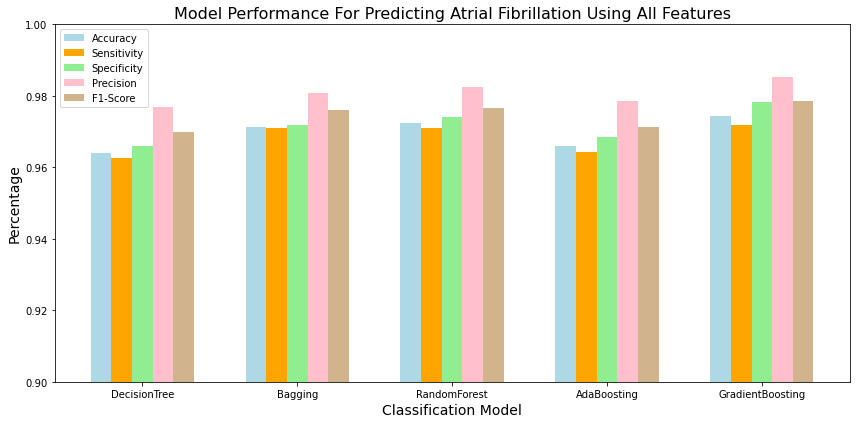

In [25]:
models = ['DecisionTree', 'Bagging', 'RandomForest', 'AdaBoosting', 'GradientBoosting']
accuracies = stattrees_dic["Accuracy"]
sensitivities = stattrees_dic["Sensitivity"]
specificities = stattrees_dic["Specificity"]
precisions = stattrees_dic["Precision"]
f1_scores = stattrees_dic["F1-Score"]



x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color="lightblue")
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color="orange")
spe = ax.bar(x,specificities, width, label='Specificity', color="lightgreen")
pre = ax.bar(x+width, precisions, width, label='Precision', color="pink")
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1-Score', color="tan")

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Atrial Fibrillation Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set(ylim=(0.9, 1.0))
ax.legend()

#ax.bar_label(acc, padding=3)
#ax.bar_label(sen, padding=3)
#ax.bar_label(spe, padding=3)
#ax.bar_label(pre, padding=3)
#ax.bar_label(f1, padding=3)


fig.tight_layout()

plt.legend(loc="upper left")
plt.show()

fig.savefig('TreeResults.png')
#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

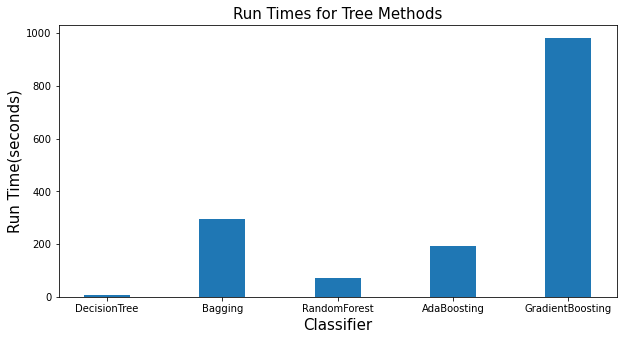

In [19]:
#Run Times

models = ['DecisionTree', 'Bagging', 'RandomForest', 'AdaBoosting', 'GradientBoosting']
width = 0.4
fig=plt.figure(figsize=(10,5))


runtimes = stattrees_dic['Run Time'] 
plt.bar(models, runtimes, width)

plt.xlabel('Classifier', fontsize=15)
plt.ylabel('Run Time(seconds)', fontsize=15)
plt.title('Run Times for Tree Methods', fontsize=15)


plt.show()

fig.savefig('TreesRunTimes.png')

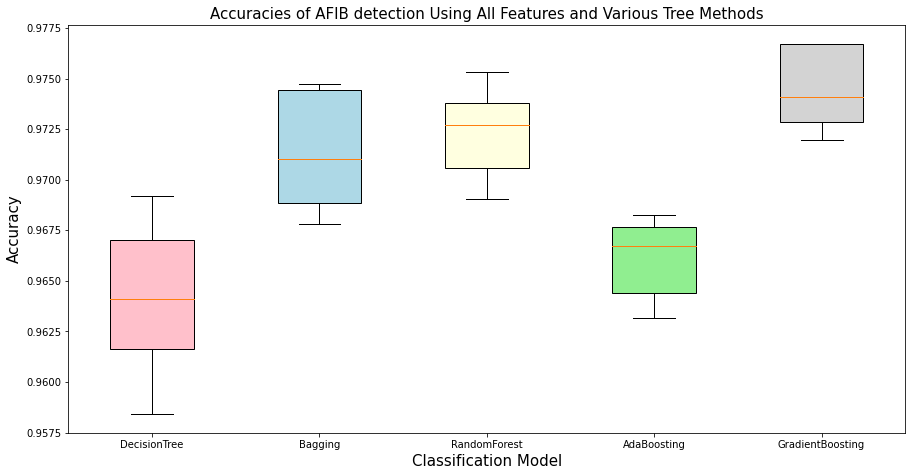

In [21]:
#Box Plot Accuracies

models = ['DecisionTree', 'Bagging', 'RandomForest', 'AdaBoosting', 'GradientBoosting']

x = np.arange(len(models))+1

DTAcc = indaccs_dic['Decision Tree']
BagAcc = indaccs_dic['Bagging']
RFAcc = indaccs_dic['Random Forest']
AdaBAcc = indaccs_dic['Ada Boosting']
GraBAcc = indaccs_dic['Gradient Boosting']

data = [DTAcc, BagAcc, RFAcc, AdaBAcc, GraBAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features and Various Tree Methods', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

colors = ['pink', 'lightblue', 'lightyellow', 'lightgreen', 'lightgrey']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

fig.savefig('TreeAccuraciesBoxPlots.png')